In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
datapath = '/content/gdrive/My Drive/NLP/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import random
import numpy as np
from keras.utils import np_utils
import keras.backend as K

Using TensorFlow backend.


In [0]:
import tensorflow as tf

In [0]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 92kB 10.0MB/s 
     |████████████████████████████████| 645kB 50.8MB/s 


In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import io
import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [0]:
def create_data(file):
  text = file.read()
  fields = ['#','$','%', '^','&','*','@','/','//','\\','[',']','(',')', 'https','http','.','co','....','..']
  entries = [j.split('\n') for j in text.split('\n\n')]
  data = {'text':[], 'lang':[], 'tag':[]}
  for entry in entries:
    sent = entry[0].split('\t')[-1]
    if sent == 'positive':
      data['tag'].append(0)
    elif sent=='negative':
      data['tag'].append(1)
    else:
      data['tag'].append(2)
    words = []
    langs = []
    for wordl in entry[1:]:
      word, lang = wordl.split('\t')
      if word not in fields and word[0] not in fields:
        words.append(word)
        langs.append(lang)
    data['text'].append('[CLS] '+' '.join(words)+' [SEP]')
    data['lang'].append(langs)
  return data

In [0]:
with open(datapath+'train.txt', 'r') as f:
  trainval = create_data(f)
with open(datapath+'test.txt', 'r') as f:
  test = create_data(f)

In [0]:
test = pd.DataFrame(test)
trainval = pd.DataFrame(trainval)

In [0]:
SPLIT = 0.1
MAXLEN_WORD = 128
MAXLEN_SENT = 178
EMB_FEATURES = 256

In [0]:
test

,text,lang,tag
0,[CLS] RT UAAPconfessions Love looks good on Ma...,"[Eng, Eng, Eng, Eng, Eng, Eng, Eng, O, Eng, En...",2
1,[CLS] Ye Ye ..... ye ??????? We gonna start an...,"[Hin, Hin, O, Hin, O, Hin, Hin, Eng, Eng, Eng,...",2
2,[CLS] zWffFY9JGklElA1 Min _ Of _ Lyching thaku...,"[Eng, Eng, O, Hin, O, Eng, Eng, Eng, Hin, Hin,...",2
3,[CLS] ~ Caring . ~ Bohot Jyada Caring . ~ Cour...,"[O, Eng, O, O, Hin, Hin, Eng, O, O, Eng, Eng, ...",1
4,[CLS] AliHZaidiPTI SarfarazA _ 54 What nonesen...,"[Hin, Hin, O, O, Hin, Eng, O, Hin, Hin, Eng, H...",0
...,...,...,...
1865,[CLS] AmnaKhanPMLN 1992 ma Duain kabool hui th...,"[Hin, O, Hin, Hin, Hin, Hin, Hin, Hin, Hin, Hi...",0
1866,[CLS] javerias Jo harami video bna rha he ye a...,"[Eng, Hin, Hin, Hin, Hin, Hin, Hin, Hin, Hin, ...",2
1867,[CLS] RT falasizz FUCK MS THORPE FUCK MS BAAJ ...,"[Hin, Hin, Eng, Hin, Hin, Eng, Hin, Hin, Eng, ...",1
1868,[CLS] jigneshmevani80 dgpgujarat AhmedabadPoli...,"[Eng, Eng, Hin, Hin, Hin, Hin, Hin, Hin, Hin, ...",1


In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

100%|██████████| 871891/871891 [00:00<00:00, 957193.24B/s]


In [0]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in trainval['text']]
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAXLEN_SENT, dtype="long", truncating="post", padding="post")

In [0]:
input_ids[0]

array([  101, 81393, 12905, 10370, 20781, 10123, 14897, 10237, 23550,
       10281, 16387, 11561, 10191, 14897, 12847, 11236, 17439, 25745,
       10150, 18114, 10262, 25275, 10211, 10127, 10457, 30646, 11009,
       31340, 10191,   118, 27895, 30646,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [0]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, [[j] for j in trainval['tag']], 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 16

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [0]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels=3)
model.cuda()

100%|██████████| 623743758/623743758 [07:10<00:00, 1449815.68B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
  

In [0]:
def recall_m(y_pred, y_true):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_pred, y_true):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_pred, y_true):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [0]:
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

In [0]:
# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask.long(), labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy, eval_f1, eval_precision, eval_recall = 0, 0, 0, 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask.long())    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    #eval_f1 += f1_m(logits, label_ids)
    #eval_recall += recall_m(logits, label_ids)
    #eval_precision += precision_m(logits, label_ids)
    nb_eval_steps += 1
  #print("Val_Accuracy: {} Val_f1: {} Val_recall: {} Val_precision: {}".format(eval_accuracy/nb_eval_steps,eval_f1/nb_eval_steps,eval_recall/nb_eval_steps,eval_precision/nb_eval_steps))
  print("Val_Accuracy: {}".format(eval_accuracy/nb_eval_steps))


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 1.099630741446231



Epoch:  25%|██▌       | 1/4 [17:10<51:31, 1030.47s/it]

Val_Accuracy: 0.37552631578947365
Train loss: 1.0945798625968433



Epoch:  50%|█████     | 2/4 [34:22<34:21, 1030.94s/it]

Val_Accuracy: 0.37552631578947365


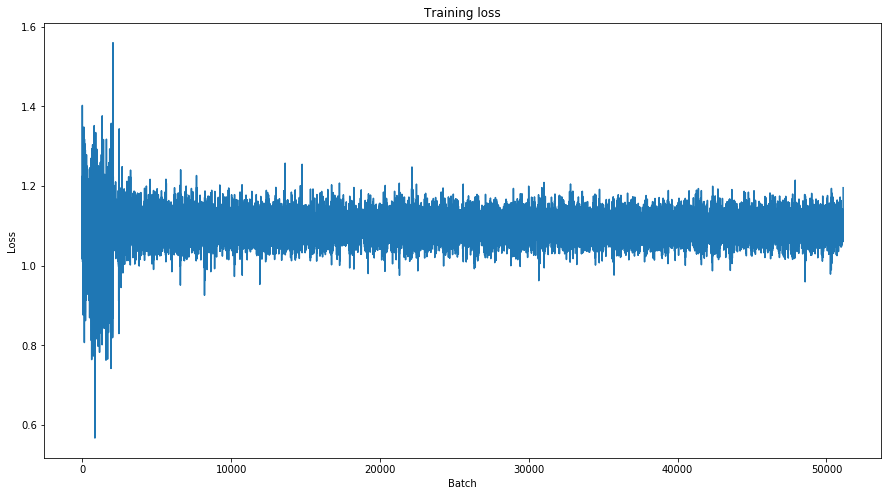

In [0]:
# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()